In [20]:
import io
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
from docx import Document
from docx.shared import Inches
import time

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

from langchain_community.llms import Ollama

model = load_model(r"C:\Users\rupin\Downloads\VIT VELLORE HACKATHON\my_model.h5")

class_labels = class_names = ['Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k',
'Seborrheic Keratoses and other Benign Tumors - 1.8k',
'Psoriasis pictures Lichen Planus and related diseases - 2k',
'Benign Keratosis-like Lesions (BKL) 2624',
'Melanocytic Nevi (NV) - 7970',
'Basal Cell Carcinoma (BCC) 3323',
'Atopic Dermatitis - 1.25k',
'Melanoma 15.75k',
'Warts Molluscum and other Viral Infections - 2103',
'Eczema 1677']

llm = Ollama(model="Medical")



def predict_skin_disease(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    return predicted_class, predictions.max(), img[0]



def send_diagnosis_report(patient_name, patient_email, diagnosis_report, app_password, attachment_path=None):
    # Email configurations
    smtp_server = "smtp.gmail.com"
    smtp_port = 587  # For Gmail
    sender_email = "medilink0000@gmail.com"  # Your Gmail address
    recipient_email = patient_email
    subject = "Diagnosis Report for " + patient_name

    # Create a message container
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = recipient_email
    message["Subject"] = subject

    # Attach the diagnosis report
    message.attach(MIMEText(diagnosis_report, "plain"))

    if attachment_path:
        # Attach the Word file
        with open(attachment_path, "rb") as attachment:
            part = MIMEBase("application", "octet-stream")
            part.set_payload(attachment.read())
            encoders.encode_base64(part)
            part.add_header("Content-Disposition", f"attachment; filename=diagnosis_report.docx")
            message.attach(part)

    try:
        # Connect to the SMTP server
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()

        # Log in with the App Password
        server.login(sender_email, app_password)

        # Send the email
        server.sendmail(sender_email, recipient_email, message.as_string())

        # Quit the server
        server.quit()

        print(f"Email sent to {patient_name} at {patient_email}")

    except Exception as e:
        print(f"Failed to send email: {str(e)}")

# Function to perform diagnosis and send report
def perform_diagnosis_and_send_report(image_path, patient_name, patient_email, app_password):
    # Perform the skin disease prediction and get information
    predicted_class, confidence, input_image = predict_skin_disease(image_path)
    info = llm.invoke(predicted_class + ", make it short")


    # Create a figure to display the image and the predicted disease
    plt.figure()
    plt.imshow(input_image)
    plt.title("Input Image - Predicted: " + predicted_class)
    plt.axis('off')

    # Create a timestamp to make the document name unique
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    document_name = f"Skin_Disease_Prediction_{timestamp}.docx"

    # Save the result to a Word document
    doc = Document()
    doc.add_heading("Skin Disease Prediction - DermAI", 0)

    doc.add_heading("Predicted Disease:", level=1)
    doc.add_paragraph(predicted_class)

    doc.add_heading("Accuracy:", level=1)
    doc.add_paragraph(f"{confidence * 100:.2f}%")

    input_image_path = "input_image.jpg"
    input_image = (input_image * 255).astype(np.uint8)
    Image.fromarray(input_image).save(input_image_path)

    doc.add_heading("Input Image:", level=1)
    doc.add_picture(input_image_path, width=Inches(4.5))

    # Include description and treatment information if available
    if info:
        doc.add_heading("Disease Description:", level=1)
        doc.add_paragraph(info)

        #doc.add_heading("Treatment Methods:", level=1)
        #doc.add_paragraph(llm.invoke(predicted_class + "Disease description max 50 words"))
        
    doc.save(document_name)

    # Send the diagnosis report via email
    send_diagnosis_report(patient_name, patient_email, "Diagnosis Report", app_password, document_name)

    # Show the input image and the predicted disease
    plt.show()

    print(f"Results saved to '{document_name}' and email sent to {patient_name} at {patient_email}")



Enter the path to the image: C:\Users\rupin\Downloads\VIT VELLORE HACKATHON\Melanocytic nevus.jpg
Enter Patient Name:testfinal
Enter Patient Email Id:rupinajay14@gmail.com
1/1 [==============================] - 26s 26s/step
Email sent to testfinal at rupinajay14@gmail.com


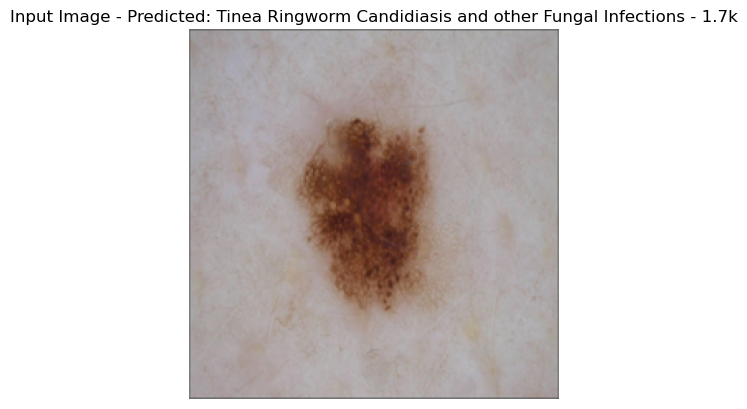

Results saved to 'Skin_Disease_Prediction_20240223-131748.docx' and email sent to testfinal at rupinajay14@gmail.com


In [21]:
app_password = "lpjd ginj ifij qqjz"  # Replace with your actual App Password
image_path = input("Enter the path to the image: ")
patient_name = input("Enter Patient Name:")
patient_email = input("Enter Patient Email Id:")
perform_diagnosis_and_send_report(image_path, patient_name, patient_email, app_password)

# Assuming predicted_class is already defined